In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.5 MB/s eta 0:00:00


In [ ]:
!pip install nilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 74.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 106.9 MB/s eta 0:00:00
  Attempting uninstall: nibabel
    Found existing installation: nibabel 3.0.2
    Uninstalling nibabel-3.0.2:
      Successfully uninstalled nibabel-3.0.2


In [ ]:
!pip install nibabel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install albumentations==0.4.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65156 sha256=bd45250abfd75abce53cf2ce1a78fbb41f01f32194f769bad6d0b7f27073be32
  Stored in directory: /root/.cache/pip/wheels/f9/d7/0c/6ed42fd872f7d1af78b25045f8b16be330f2c70ae72c83e37d
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1


In [ ]:
#Requirements
from tqdm import tqdm
import os
import time
from random import randint
import numpy as np
from scipy import stats
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as anim
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import seaborn as sns
import imageio
from skimage.transform import resize
from skimage.util import montage

import nibabel as nib
import pydicom as pdm
import nilearn as nl
import nilearn.plotting as nlplt
import h5py

from IPython.display import Image as show_gif
from IPython.display import clear_output
from IPython.display import YouTubeVideo

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import MSELoss
from torchsummary import summary

import albumentations as A
from albumentations import Compose, HorizontalFlip
from albumentations.pytorch.transforms import ToTensor, ToTensorV2 

import warnings
warnings.simplefilter("ignore")

**(1) Configure Class for defining path**

In [ ]:
"""
Class global config contains path for root directory train root directory and test root directory 
as well as path to csv genereated by the survival and name mapping csv in the next code block
"""

class GlobalConfigurations:
    root_dir = '/content/drive/Shareddrives/cs231n_final/cs231n_baseline/BraTS2020'
    train_root_dir = '/content/drive/Shareddrives/cs231n_final/cs231n_baseline/BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
    test_root_dir = '/content/drive/Shareddrives/cs231n_final/cs231n_baseline/BraTS2020/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'
    path_to_csv = '/content/drive/Shareddrives/cs231n_final/cs231n_baseline/train_data.csv'
    seed = 55
    
def seed_everything(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    
config = GlobalConfigurations()
seed_everything(config.seed)

**(2) Generate Training and Testing Data**

In [ ]:
"""
train_data.csv file will be generated using this code block which contains ID, path for each image data, survival info, age_rank and different grades for tumor.
Basically this file takes BraTS20ID as an inner join and then set paths using config class and take age rank whereas the values of age is not null. 
It also add fold column which divides train and validation data with 1-6,0 notation respectively.
At the end it generates train_data.csv file using to_csv method.
"""
survival_information_df = pd.read_csv('/content/drive/Shareddrives/cs231n_final/survival_info.csv')
mapping_name_df = pd.read_csv('/content/drive/Shareddrives/cs231n_final/name_mapping.csv')

mapping_name_df.rename({'BraTS_2020_subject_ID': 'Brats20ID'}, axis=1, inplace=True) 


df = survival_information_df.merge(mapping_name_df, on="Brats20ID", how="right")

name_paths = []
for _, row  in df.iterrows():
    
    id_ = row['Brats20ID']
    phase = id_.split("_")[-2]
    
    if phase == 'Training':
        path = os.path.join(config.train_root_dir, id_)
    else:
        path = os.path.join(config.test_root_dir, id_)
    name_paths.append(path)
    
df['path'] = name_paths

train_df, val_df = train_test_split(df, train_size=0.9, random_state=69, shuffle=True)
train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)

train_df, test_df = train_test_split(train_df, test_size=0.3, random_state=69, shuffle=True)
train_df, test_df = train_df.reset_index(drop=True), test_df.reset_index(drop=True)

train_data = df.loc[df['Age'].notnull()].reset_index(drop=True)
train_data["Age_rank"] =  train_data["Age"] // 10 * 10
train_data = train_data.loc[train_data['Brats20ID'] != 'BraTS20_Training_355'].reset_index(drop=True, )

stratifiedkfold = StratifiedKFold(
    n_splits=7, random_state=config.seed, shuffle=True
)
for i, (train_index, val_index) in enumerate(
        stratifiedkfold.split(train_data, train_data["Age_rank"])
            ):
            train_data.loc[val_index, "fold"] = i

print("train_df ->", train_df.shape, "val_df ->", val_df.shape, "test_df ->", test_df.shape)
train_data.to_csv("/content/drive/Shareddrives/cs231n_final/cs231n_baseline/train_data.csv", index=False)

train_df -> (232, 10) val_df -> (37, 10) test_df -> (100, 10)


In [ ]:
#This block check the sample image shape and mask shape of individual images
filename_sample = '/content/drive/Shareddrives/cs231n_final/cs231n_baseline/BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_214/BraTS20_Training_214_flair.nii'
filename_sample_mask = '/content/drive/Shareddrives/cs231n_final/cs231n_baseline/BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_214/BraTS20_Training_214_seg.nii'

sample_image = nib.load(filename_sample)
sample_image = np.asanyarray(sample_image.dataobj)
sample_image = np.rot90(sample_image)
mask_sample = nib.load(filename_sample_mask)
mask_sample = np.asanyarray(mask_sample.dataobj)
mask_sample = np.rot90(mask_sample)
print("img shape ->", sample_image.shape)
print("mask shape ->", mask_sample.shape)

filename_sample2 = '/content/drive/Shareddrives/cs231n_final/cs231n_baseline/BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1.nii'
sample_image2 = nib.load(filename_sample2)
sample_image2 = np.asanyarray(sample_image2.dataobj)
sample_image2  = np.rot90(sample_image2)

filename_sample3 = '/content/drive/Shareddrives/cs231n_final/cs231n_baseline/BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t2.nii'
sample_image3 = nib.load(filename_sample3)
sample_image3 = np.asanyarray(sample_image3.dataobj)
sample_image3  = np.rot90(sample_image3)

filename_sample4 = '/content/drive/Shareddrives/cs231n_final/cs231n_baseline/BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii'
sample_image4 = nib.load(filename_sample4)
sample_image4 = np.asanyarray(sample_image4.dataobj)
sample_image4  = np.rot90(sample_image4)

mask_WT = mask_sample.copy()
mask_WT[mask_WT == 1] = 1
mask_WT[mask_WT == 2] = 1
mask_WT[mask_WT == 4] = 1

mask_TC = mask_sample.copy()
mask_TC[mask_TC == 1] = 1
mask_TC[mask_TC == 2] = 0
mask_TC[mask_TC == 4] = 1

mask_ET = mask_sample.copy()
mask_ET[mask_ET == 1] = 0
mask_ET[mask_ET == 2] = 0
mask_ET[mask_ET == 4] = 1
     


img shape -> (240, 240, 155)
mask shape -> (240, 240, 155)


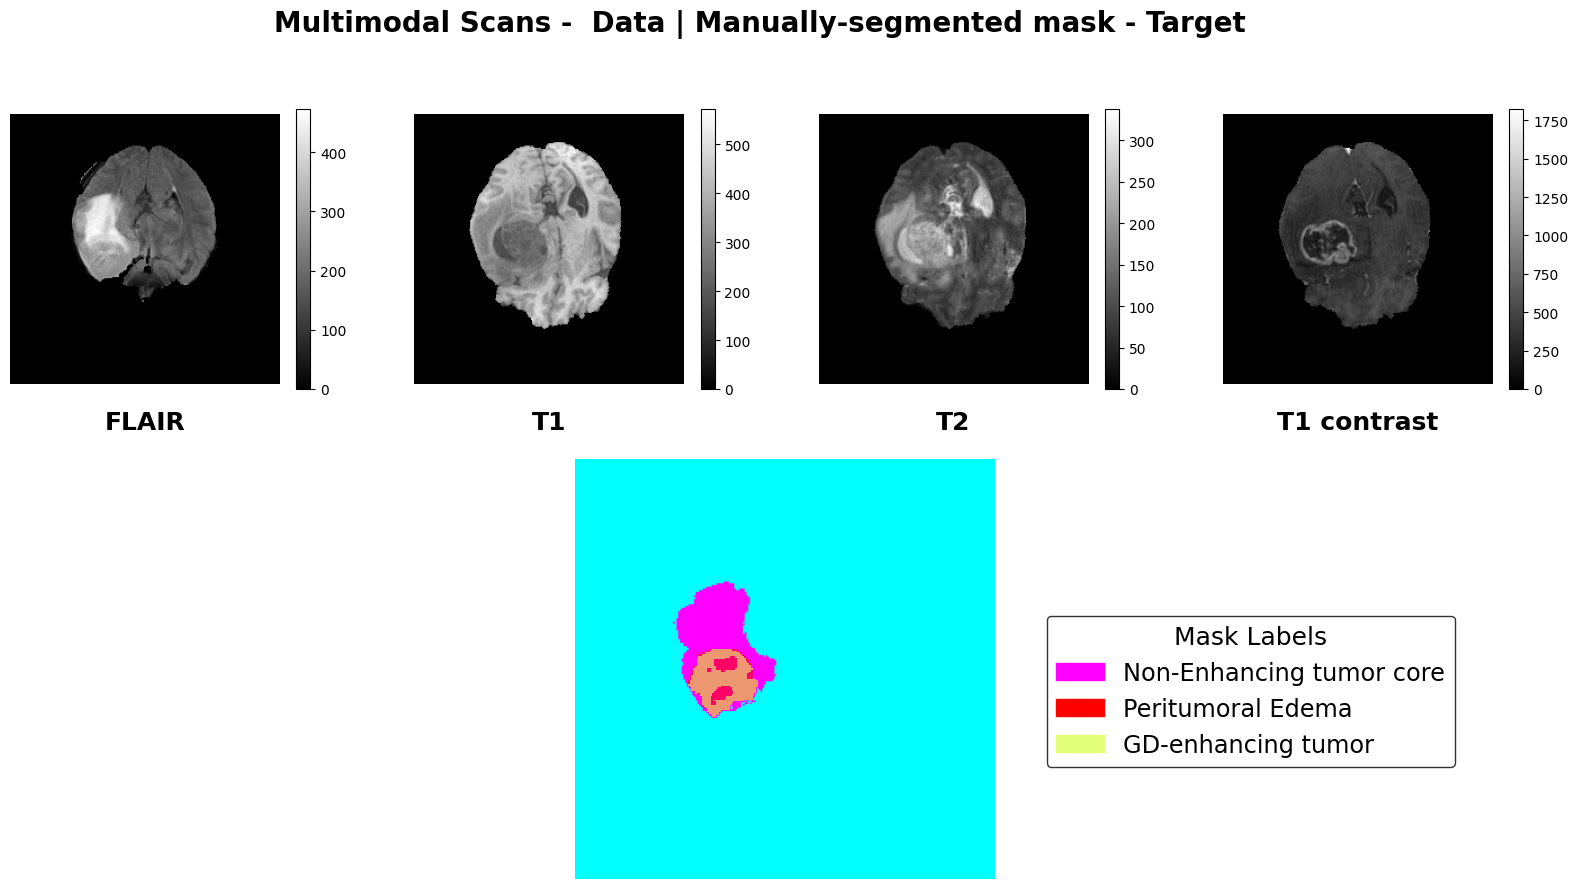

In [ ]:
fig = plt.figure(figsize=(20, 10))

gs = gridspec.GridSpec(nrows=2, ncols=4, height_ratios=[1, 1.5])

#Flair
ax0 = fig.add_subplot(gs[0, 0])
flair = ax0.imshow(sample_image[:,:,65], cmap='gist_gray')
ax0.set_title("FLAIR", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(flair)

#T1
ax1 = fig.add_subplot(gs[0, 1])
t1 = ax1.imshow(sample_image2[:,:,65], cmap='gist_gray')
ax1.set_title("T1", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(t1)

#T2
ax2 = fig.add_subplot(gs[0, 2])
t2 = ax2.imshow(sample_image3[:,:,65], cmap='gist_gray')
ax2.set_title("T2", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(t2)

#T1ce
ax3 = fig.add_subplot(gs[0, 3])
t1ce = ax3.imshow(sample_image4[:,:,65], cmap='gist_gray')
ax3.set_title("T1 contrast", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(t1ce)


#mask
ax4 = fig.add_subplot(gs[1, 1:3])


l1 = ax4.imshow(mask_WT[:,:,65], cmap='cool',)
l2 = ax4.imshow(np.ma.masked_where(mask_TC[:,:,65]== False,  mask_TC[:,:,65]), cmap='hsv', alpha=0.6)
l3 = ax4.imshow(np.ma.masked_where(mask_ET[:,:,65] == False, mask_ET[:,:,65]), cmap='Wistia', alpha=0.6)

ax4.set_title("", fontsize=20, weight='bold', y=-0.1)

_ = [ax.set_axis_off() for ax in [ax0,ax1,ax2,ax3, ax4]]

colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]
labels = ['Non-Enhancing tumor core', 'Peritumoral Edema ', 'GD-enhancing tumor']
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]
# legends
plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 'xx-large',
           title='Mask Labels', title_fontsize=18, edgecolor="black",  facecolor='white')

plt.suptitle("Multimodal Scans -  Data | Manually-segmented mask - Target", fontsize=20, weight='bold')

fig.savefig("data_sample.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("data_sample.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')


**(3) Data Augmentation and Data Loader Initialization**

In [ ]:
#performs augmentation on image such as horizonatalflip and random brightness contrast using albumentations library.
def augmentation(phase):
    transformation_list = [
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),]
    
    augmented_list = Compose(transformation_list)
    return augmented_list

#takes arguments for dataset, path_to_csv(train_data.csv), number of fold and number of workers and return training data for model
def get_dataloader(
    dataset: torch.utils.data.Dataset,
    path_to_csv: str,
    phase: str,
    fold: int = 0,
    batch_size: int = 1,
    num_workers: int = 4,
):

    df = pd.read_csv(path_to_csv)
    
    train_df = df.loc[df['fold'] != fold].reset_index(drop=True)
    val_df = df.loc[df['fold'] == fold].reset_index(drop=True)

    df = train_df if phase == "train" else val_df
    dataset = dataset(df, phase)
    data_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,   
    )
    return data_loader

**(4) Generate Final Training & Testing Dataset**

In [ ]:
#this class returns training data and testing data with data augmentations normalizations, image resize.
#for normalization it uses (original data - mininum of original data)/(maximum of original data - minimum of original data)
#it also returns ID, image and mask for dataloader.

class BratsDataset(Dataset):
    def __init__(self, df: pd.DataFrame, phase: str="test", is_resize: bool=False):
        self.df = df
        self.phase = phase
        self.augmentations = augmentation(phase)
        self.data_types = ['_flair.nii', '_t1.nii', '_t1ce.nii', '_t2.nii']
        self.is_resize = is_resize
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        id_ = self.df.loc[idx, 'Brats20ID']
        root_path = self.df.loc[self.df['Brats20ID'] == id_]['path'].values[0]
        # load all modalities
        images = []
        for data_type in self.data_types:
            image_path = os.path.join(root_path, id_ + data_type)
            image = self.load_image(image_path)#.transpose(2, 0, 1)
            
            if self.is_resize:
                image = self.resize(image)
    
            image = self.normalize(image)
            images.append(image)
        image = np.stack(images)
        image = np.moveaxis(image, (0, 1, 2, 3), (0, 3, 2, 1))
        
        if self.phase != "test":
            mask_path =  os.path.join(root_path, id_ + "_seg.nii")
            mask = self.load_image(mask_path)
            
            if self.is_resize:
                mask = self.resize(mask)
                mask = np.clip(mask.astype(np.uint8), 0, 1).astype(np.float32)
                mask = np.clip(mask, 0, 1)
            mask = self.preprocess_mask_labels(mask)
    
            augmented = self.augmentations(image=image.astype(np.float32), 
                                           mask=mask.astype(np.float32))
            
            image = augmented['image']
            mask = augmented['mask']
    
        
            return {
                "Id": id_,
                "image": image,
                "mask": mask,
            }
        
        return {
            "Id": id_,
            "image": image,
        }
        
    def load_image(self, file_path):
        data = nib.load(file_path)
        data = np.asarray(data.dataobj)
        return data
    
    def normalize(self, data: np.ndarray):
        data_min = np.min(data)
        return (data - data_min) / (np.max(data) - data_min)
    
    def resize(self, data: np.ndarray):
        data = resize(data, (78, 120, 120), preserve_range=True)
        return data
    
    def preprocess_mask_labels(self, mask: np.ndarray):

        mask_WT = mask.copy()
        mask_WT[mask_WT == 1] = 1
        mask_WT[mask_WT == 2] = 1
        mask_WT[mask_WT == 4] = 1

        mask_TC = mask.copy()
        mask_TC[mask_TC == 1] = 1
        mask_TC[mask_TC == 2] = 0
        mask_TC[mask_TC == 4] = 1

        mask_ET = mask.copy()
        mask_ET[mask_ET == 1] = 0
        mask_ET[mask_ET == 2] = 0
        mask_ET[mask_ET == 4] = 1

        mask = np.stack([mask_WT, mask_TC, mask_ET])
        mask = np.moveaxis(mask, (0, 1, 2, 3), (0, 3, 2, 1))

        return mask  

In [ ]:
#It gets data from get_dataloader method and make the data ready for training purpose
data_loader = get_dataloader(dataset=BratsDataset, path_to_csv='/content/drive/Shareddrives/cs231n_final/cs231n_baseline/train_data.csv', phase='valid', fold=3)
len(data_loader)

34

In [ ]:
# it stores id image and mask of each individual image and 
# gives the torch size on which data is going to be trained.
data = next(iter(data_loader))
data['Id'], data['image'].shape, data['mask'].shape

(['BraTS20_Training_167'],
 torch.Size([1, 4, 155, 240, 240]),
 torch.Size([1, 3, 155, 240, 240]))

**(5) Metrics Calculation for Model Evaluation**

In [ ]:
"""
Calculates Dice coeffient metric for data batch it return dice score.
It takes model output after activation function, truth values and threshold for calculations.
"""
def dice_coef_metric(probabilities: torch.Tensor,
                     truth: torch.Tensor,
                     treshold: float = 0.5,
                     eps: float = 1e-9) -> np.ndarray:
    
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)
    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = 2.0 * (truth_ * prediction).sum()
        union = truth_.sum() + prediction.sum()
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)

"""
Calculates Jaccard Score for data batch it return dice score.
It takes model output after activation function, truth values and threshold for calculations.
"""
def jaccard_coef_metric(probabilities: torch.Tensor,
               truth: torch.Tensor,
               treshold: float = 0.5,
               eps: float = 1e-9) -> np.ndarray:

    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)

    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = (prediction * truth_).sum()
        union = (prediction.sum() + truth_.sum()) - intersection + eps
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)

'''
It stores and update and return dice and iou scores.
def_update: it takes logits from output model and targets and calculates dice and iou scores.
get_metric: It returns the average of accumulated dice and iou scores.
'''
class Meter:
    
    def __init__(self, treshold: float = 0.5):
        self.threshold: float = treshold
        self.dice_scores: list = []
        self.iou_scores: list = []
    
    def update(self, logits: torch.Tensor, targets: torch.Tensor):
        
        probs = torch.sigmoid(logits)
        dice = dice_coef_metric(probs, targets, self.threshold)
        iou = jaccard_coef_metric(probs, targets, self.threshold)
        
        self.dice_scores.append(dice)
        self.iou_scores.append(iou)
    
    def get_metrics(self) -> np.ndarray:

        dice = np.mean(self.dice_scores)
        iou = np.mean(self.iou_scores)
        return dice, iou

#calculates dice loss
class DiceLoss(nn.Module):
    def __init__(self, eps: float = 1e-9):
        super(DiceLoss, self).__init__()
        self.eps = eps
        
    def forward(self,
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:
        
        num = targets.size(0)
        probability = torch.sigmoid(logits)
        probability = probability.view(num, -1)
        targets = targets.view(num, -1)
        assert(probability.shape == targets.shape)
        
        intersection = 2.0 * (probability * targets).sum()
        union = probability.sum() + targets.sum()
        dice_score = (intersection + self.eps) / union
        
        return 1.0 - dice_score

#computes total loss: binary cross entropy loss with addition to dice loss.        
class BCEDiceLoss(nn.Module):
    def __init__(self):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        
    def forward(self, 
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:
        assert(logits.shape == targets.shape)
        dice_loss = self.dice(logits, targets)
        bce_loss = self.bce(logits, targets)
        
        return bce_loss + dice_loss
    
"""
Calculates Dice score for each class from the data.
It considers model outputs after activation function, model targets, threshold, different classes for calculation.
It return dictionary with dice score for individual classes.
"""  
def dice_coef_metric_per_classes(probabilities: np.ndarray,
                                    truth: np.ndarray,
                                    treshold: float = 0.5,
                                    eps: float = 1e-9,
                                    classes: list = ['WT', 'TC', 'ET']) -> np.ndarray:
    
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = 2.0 * (truth_ * prediction).sum()
            union = truth_.sum() + prediction.sum()
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)
                
    return scores

"""
Calculates Jaccard Index for each class from the data.
It considers model outputs after activation function, model targets, threshold, different classes for calculation.
It returns dictionary with jaccard score for individual classes
"""
def jaccard_coef_metric_per_classes(probabilities: np.ndarray,
               truth: np.ndarray,
               treshold: float = 0.5,
               eps: float = 1e-9,
               classes: list = ['WT', 'TC', 'ET']) -> np.ndarray:
    
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = (prediction * truth_).sum()
            union = (prediction.sum() + truth_.sum()) - intersection + eps
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)

    return scores    

**(6) Architecture of 3D UNet**

In [ ]:
class DoubleConv(nn.Module):

    def __init__(self, in_channels, out_channels, num_groups=8):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm3d(out_channels),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            nn.ReLU(inplace=True),

            nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm3d(out_channels),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            nn.ReLU(inplace=True)
          )

    def forward(self,x):
        return self.double_conv(x)

    
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool3d(2, 2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.encoder(x)

    
class Up(nn.Module):

    def __init__(self, in_channels, out_channels, trilinear=True):
        super().__init__()
        
        if trilinear:
            self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose3d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
            
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffZ = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        diffX = x2.size()[4] - x1.size()[4]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2, diffZ // 2, diffZ - diffZ // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class Out(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size = 1)

    def forward(self, x):
        return self.conv(x)


class UNet3d(nn.Module):
    def __init__(self, in_channels, n_classes, n_channels):
        super().__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes
        self.n_channels = n_channels

        self.conv = DoubleConv(in_channels, n_channels)
        self.enc1 = Down(n_channels, 2 * n_channels)
        self.enc2 = Down(2 * n_channels, 4 * n_channels)
        self.enc3 = Down(4 * n_channels, 8 * n_channels)
        self.enc4 = Down(8 * n_channels, 16 * n_channels)
        self.enc5 = Down(16 * n_channels, 16 * n_channels)

        self.dec1 = Up(32 * n_channels, 8 * n_channels)
        self.dec2 = Up(16 * n_channels, 4 * n_channels)
        self.dec3 = Up(8 * n_channels, 2 * n_channels)
        self.dec4 = Up(4 * n_channels, n_channels)
        self.dec5 = Up(2 * n_channels, n_channels)
        self.out = Out(n_channels, n_classes)

    def forward(self, x):
        
        x1 = self.conv(x)
        x2 = self.enc1(x1)
        x3 = self.enc2(x2)
        x4 = self.enc3(x3)
        x5 = self.enc4(x4)
        x6 = self.enc5(x5)


        mask = self.dec1(x6, x5)
        mask = self.dec2(mask, x4)
        mask = self.dec3(mask, x3)
        mask = self.dec4(mask, x2)
        mask = self.dec5(mask, x1)
        mask = self.out(mask)
        
        return mask

**(7) Model Training and Initialization**

In [ ]:
"""
It sets the paramter for model training: dataset, criterion, learning_rate, schedular, 
                                         batch size, optimizers.
def compute_loss and outputs: return loss and logits.
def do_epoch: perform epoch for training process calculates logits and loss for each epoch and returns epoch loss.
def run: run the epoch and saves best model at the given path.
def plot_train_history: plots the train history for after every epoch.
"""
class Trainer:
    
    def __init__(self,
                 net: nn.Module,
                 dataset: torch.utils.data.Dataset,
                 criterion: nn.Module,
                 lr: float,
                 accumulation_steps: int,
                 batch_size: int,
                 fold: int,
                 num_epochs: int,
                 path_to_csv: str,
                 display_plot: bool = True,
                ):

        #training initialization
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print("device:", self.device)
        self.display_plot = display_plot
        self.net = net
        self.net = self.net.to(self.device)
        self.criterion = criterion
        self.optimizer = Adam(self.net.parameters(), lr=lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min",
                                           patience=2, verbose=True)
        self.accumulation_steps = accumulation_steps // batch_size
        self.phases = ["train", "val"]
        self.num_epochs = num_epochs

        self.dataloaders = {
            phase: get_dataloader(
                dataset = dataset,
                path_to_csv = path_to_csv,
                phase = phase,
                fold = fold,
                batch_size = batch_size,
                num_workers = 4
            )
            for phase in self.phases
        }
        self.best_loss = float("inf")
        self.losses = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        self.jaccard_scores = {phase: [] for phase in self.phases}
         
    #compute loss for each epoch
    def compute_loss_and_outputs(self,
                                  images: torch.Tensor,
                                  targets: torch.Tensor):
        images = images.to(self.device)
        targets = targets.to(self.device)
        logits = self.net(images)
        loss = self.criterion(logits, targets)
        return loss, logits
    
    #perform epochs    
    def do_epoch(self, epoch: int, phase: str):
        print(f"{phase} epoch: {epoch}")

        self.net.train() if phase == "train" else self.net.eval()
        meter = Meter()
        data_loader = self.dataloaders[phase]
        total_batches = len(data_loader)
        running_loss = 0.0
        self.optimizer.zero_grad()
        for itr, data_batch in enumerate(data_loader):
            images, targets = data_batch['image'], data_batch['mask']
            loss, logits = self.compute_loss_and_outputs(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            meter.update(logits.detach().cpu(),
                         targets.detach().cpu()
                        )
            
        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        epoch_dice, epoch_iou = meter.get_metrics()
        
        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(epoch_dice)
        self.jaccard_scores[phase].append(epoch_iou)

        return epoch_loss
        
    #run epochs
    def run(self):
        for epoch in range(self.num_epochs):
            self.do_epoch(epoch, "train")
            with torch.no_grad():
                val_loss = self.do_epoch(epoch, "val")
                self.scheduler.step(val_loss)
            if self.display_plot:
                self.plot_train_history()
                
            if val_loss < self.best_loss:
                print(f"\n{'#'*20}\nSaved new checkpoint\n{'#'*20}\n")
                self.best_loss = val_loss
                torch.save(self.net.state_dict(), "/content/drive/Shareddrives/cs231n_final/cs231n_baseline/best_model.pth")
            print()
        self.save_train_history()
    
    #plot the train and validation history graph
    def plot_train_history(self):
        data = [self.losses, self.dice_scores, self.jaccard_scores]
        colors = ['deepskyblue', "crimson"]
        labels = [
            f"""
            train loss {self.losses['train'][-1]}
            val loss {self.losses['val'][-1]}
            """,
            
            f"""
            train dice score {self.dice_scores['train'][-1]}
            val dice score {self.dice_scores['val'][-1]} 
            """, 
                  
            f"""
            train jaccard score {self.jaccard_scores['train'][-1]}
            val jaccard score {self.jaccard_scores['val'][-1]}
            """,
        ]
        
        clear_output(True)
        with plt.style.context("seaborn-dark-palette"):
            fig, axes = plt.subplots(3, 1, figsize=(8, 10))
            for i, ax in enumerate(axes):
                ax.plot(data[i]['val'], c=colors[0], label="val")
                ax.plot(data[i]['train'], c=colors[-1], label="train")
                ax.set_title(labels[i])
                ax.legend(loc="upper right")
                
            plt.tight_layout()
            plt.show()
            
    #write training logs to defined path        
    def save_train_history(self):
        
        torch.save(self.net.state_dict(),
                   f"/content/drive/Shareddrives/cs231n_final/cs231n_baseline/last_epoch_model.pth")

        logs_ = [self.losses, self.dice_scores, self.jaccard_scores]
        log_names_ = ["_loss", "_dice", "_jaccard"]
        logs = [logs_[i][key] for i in list(range(len(logs_)))
                         for key in logs_[i]]
        log_names = [key+log_names_[i] 
                     for i in list(range(len(logs_))) 
                     for key in logs_[i]
                    ]
        pd.DataFrame(
            dict(zip(log_names, logs))
        ).to_csv("/content/drive/Shareddrives/cs231n_final/cs231n_baseline/train_log.csv", index=False)
     

Num uniq Image values : 302
Min/Max Image values: 0.0 1.0
Num uniq Mask values: (array([0., 1.], dtype=float32), array([8847231,   80769]))


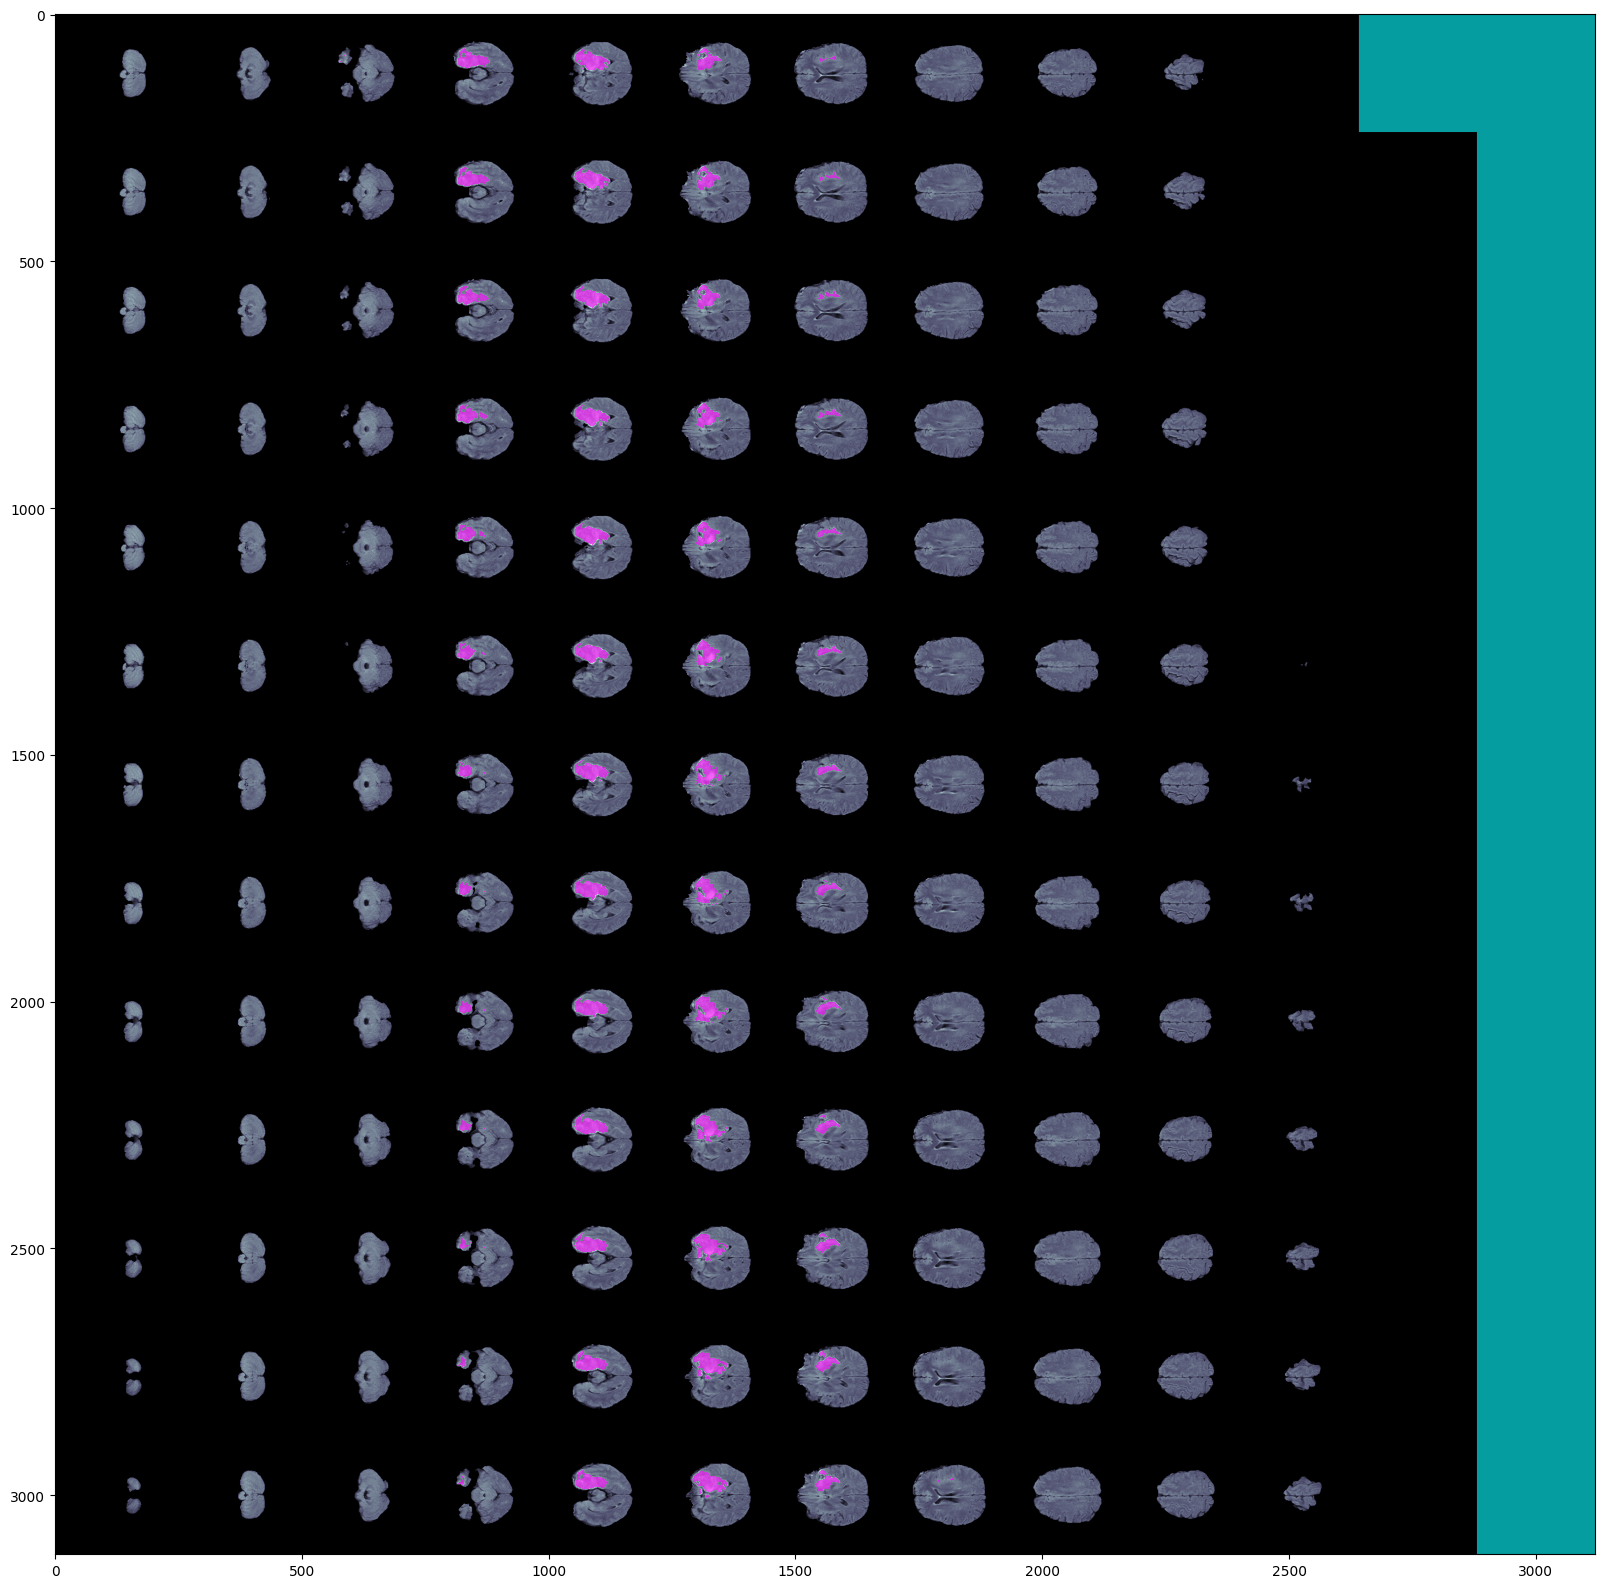

In [ ]:
tensor_image = data['image'].squeeze()[0].cpu().detach().numpy() 
tensor_mask = data['mask'].squeeze()[0].squeeze().cpu().detach().numpy()
print("Num uniq Image values :", len(np.unique(tensor_image, return_counts=True)[0]))
print("Min/Max Image values:", tensor_image.min(), tensor_image.max())
print("Num uniq Mask values:", np.unique(tensor_mask, return_counts=True))

image = np.rot90(montage(tensor_image))
mask = np.rot90(montage(tensor_mask)) 

fig, ax = plt.subplots(1, 1, figsize = (20, 20))
ax.imshow(image, cmap ='bone')
ax.imshow(np.ma.masked_where(mask == False, mask),
           cmap='cool', alpha=0.6)

**(8) Call UNet Model**

In [ ]:
#provides input parameters to model.
model = UNet3d(in_channels=4, n_classes=3, n_channels=32).to('cuda')

In [ ]:
#get model summary
summary = summary(model,(4,155,240,240))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1    [-1, 32, 155, 240, 240]           3,488
         GroupNorm-2    [-1, 32, 155, 240, 240]              64
              ReLU-3    [-1, 32, 155, 240, 240]               0
            Conv3d-4    [-1, 32, 155, 240, 240]          27,680
         GroupNorm-5    [-1, 32, 155, 240, 240]              64
              ReLU-6    [-1, 32, 155, 240, 240]               0
        DoubleConv-7    [-1, 32, 155, 240, 240]               0
         MaxPool3d-8     [-1, 32, 77, 120, 120]               0
            Conv3d-9     [-1, 64, 77, 120, 120]          55,360
        GroupNorm-10     [-1, 64, 77, 120, 120]             128
             ReLU-11     [-1, 64, 77, 120, 120]               0
           Conv3d-12     [-1, 64, 77, 120, 120]         110,656
        GroupNorm-13     [-1, 64, 77, 120, 120]             128
             ReLU-14     [-1, 64, 77, 1

**(9) Run Model**

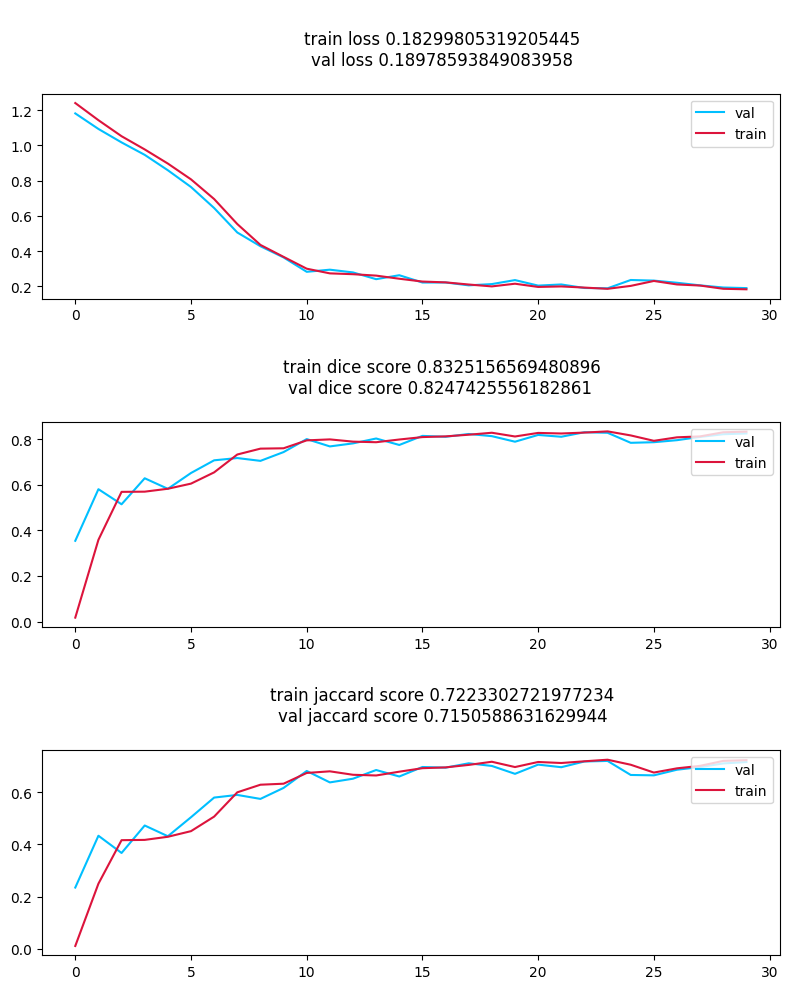

In [ ]:
#configure trainer class by providing necessary arguments and values for model training.
trainer = Trainer(net=model,
                  dataset=BratsDataset,
                  criterion=BCEDiceLoss(),
                  lr=5e-4,
                  accumulation_steps=4,
                  batch_size=1,
                  fold=3,
                  num_epochs=30,
                  path_to_csv = config.path_to_csv,)

#empty the cache data of CUDA.
torch.cuda.empty_cache()
#Run the model
trainer.run()

**(10) Computer Scores per Class**

In [ ]:
"""
It computes the dice and jaccard coefficients for individual classes(WT, TC, ET)
It uses the U-NET model and list of classes as well as the dataloader to compute the scores. 
"""

def compute_scores_per_classes(model,
                               data_loader,
                               classes):
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dice_scores_per_classes = {key: list() for key in classes}
    iou_scores_per_classes = {key: list() for key in classes}

    with torch.no_grad():
        for i, data in enumerate(data_loader):
            images, targets = data['image'], data['mask']
            images, targets = images.to(device), targets.to(device)
            logits = model(images)
            logits = logits.detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()
            
            dice_scores = dice_coef_metric_per_classes(logits, targets)
            iou_scores = jaccard_coef_metric_per_classes(logits, targets)

            for key in dice_scores.keys():
                dice_scores_per_classes[key].extend(dice_scores[key])

            for key in iou_scores.keys():
                iou_scores_per_classes[key].extend(iou_scores[key])

    return dice_scores_per_classes, iou_scores_per_classes

In [ ]:
#model evaluation
model.eval()

UNet3d(
  (conv): DoubleConv(
    (double_conv): Sequential(
      (0): Conv3d(4, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): GroupNorm(8, 32, eps=1e-05, affine=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): GroupNorm(8, 32, eps=1e-05, affine=True)
      (5): ReLU(inplace=True)
    )
  )
  (enc1): Down(
    (encoder): Sequential(
      (0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): GroupNorm(8, 64, eps=1e-05, affine=True)
          (2): ReLU(inplace=True)
          (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (4): GroupNorm(8, 64, eps=1e-05, affine=True)
          (5): ReLU(inplace=True)
        )
      )
    )
  )
  (enc2): Down(
   

In [ ]:
#validation data loader
val_dataloader = get_dataloader(BratsDataset, '/content/drive/Shareddrives/cs231n_final/cs231n_baseline/train_data.csv', phase='valid', fold=0)
len(data_loader)

34

In [ ]:
#generate validation metrics
dice_scores_per_classes, iou_scores_per_classes = compute_scores_per_classes(model, val_dataloader, ['WT', 'TC', 'ET'])

dice_df = pd.DataFrame(dice_scores_per_classes)
dice_df.columns = ['WT dice', 'TC dice', 'ET dice']

iou_df = pd.DataFrame(iou_scores_per_classes)
iou_df.columns = ['WT jaccard', 'TC jaccard', 'ET jaccard']
val_metics_df = pd.concat([dice_df, iou_df], axis=1, sort=True)
val_metics_df = val_metics_df.loc[:, ['WT dice', 'WT jaccard', 
                                      'TC dice', 'TC jaccard', 
                                      'ET dice', 'ET jaccard']]
val_metics_df.sample(5)

,WT dice,WT jaccard,TC dice,TC jaccard,ET dice,ET jaccard
33,0.913063,0.840033,0.819536,0.694248,0.787922,0.650059
18,0.877834,0.782268,0.565337,0.394055,0.315448,0.187259
15,0.942160,0.890645,0.807695,0.677424,0.789977,0.652862
6,0.881955,0.788836,0.890011,0.801819,0.841140,0.725834
19,0.919747,0.851418,0.805551,0.674413,0.867063,0.765323


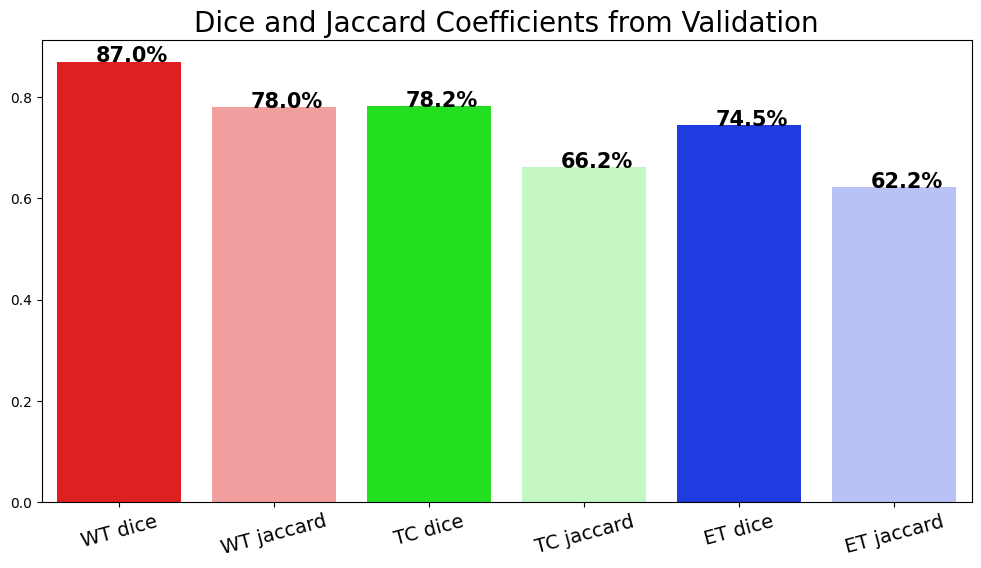

In [ ]:
#Plot the graph for individual modalities and the results
colors = ['#FF0000', '#FF9090', '#06FF00', '#BCFFBB', '#0024FF', '#AFBBFF']
palette = sns.color_palette(colors, 6)

fig, ax = plt.subplots(figsize=(12, 6));
sns.barplot(x=val_metics_df.mean().index, y=val_metics_df.mean(), palette=palette, ax=ax);
ax.set_xticklabels(val_metics_df.columns, fontsize=14, rotation=15);
ax.set_title("Dice and Jaccard Coefficients from Validation", fontsize=20)

for idx, p in enumerate(ax.patches):
        percentage = '{:.1f}%'.format(100 * val_metics_df.mean().values[idx])
        x = p.get_x() + p.get_width() / 2 - 0.15
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), fontsize=15, fontweight="bold")

fig.savefig("result1.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("result1.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')

In [ ]:
#It computes the result for ground truth and and prediction using U-NET model.
def compute_results(model,
                    data_loader,
                    treshold=0.33):

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    results = {"Id": [],"image": [], "GT": [],"Prediction": []}

    with torch.no_grad():
        for i, data in enumerate(data_loader):
            id_, images, targets = data['Id'], data['image'], data['mask']
            images, targets = images.to(device), targets.to(device)
            logits = model(images)
            probs = torch.sigmoid(logits)
            
            predictions = (probs >= treshold).float()
            predictions =  predictions.cpu()
            targets = targets.cpu()
            
            results["Id"].append(id_)
            results["image"].append(images.cpu())
            results["GT"].append(targets)
            results["Prediction"].append(predictions)
            
            # only 5 pars
            if (i > 5):    
                return results
        return results

In [ ]:
results = compute_results(model, val_dataloader, 0.33)

In [ ]:

"""
It displays the 3D Images in 3D axes.
def explode: takes numpy array and return an array twice as large in each dimension,
             with an extra space between each voxel.

def normalize: normalize the values of an image between 0 and 1.
def scale by: scale 3D image to factor for scaling.
def get_transformed_data: It returns normalized, scaled, resized image
def plot_cube: make_gif if True create gif from every 5th frames from 3d image plot and stores to given path.
"""

class ThreeDImageto3GIF:
    
    def __init__(self, 
                 image_dimension: tuple = (55, 55, 55),
                 figsize: tuple = (15, 10),
                 binary: bool = False,
                 normalizing: bool = True,
                ):
        """Initialization."""
        self.image_dimension = image_dimension
        print(image_dimension)
        self.figsize = figsize
        self.binary = binary
        self.normalizing = normalizing

    def explode(self, data: np.ndarray):
        
        shape_arr = np.array(data.shape)
        size = shape_arr[:3] * 2 - 1
        exploded = np.zeros(np.concatenate([size, shape_arr[3:]]),
                            dtype=data.dtype)
        exploded[::2, ::2, ::2] = data
        return exploded

    def expand_coordinates(self, indices: np.ndarray):
        a, b, c = indices
        a[1::2, :, :] += 1
        b[:, 1::2, :] += 1
        c[:, :, 1::2] += 1
        return a, b, c
    
    def normalize(self, arr: np.ndarray):
        
        arr_min = np.min(arr)
        return (arr - arr_min) / (np.max(arr) - arr_min)

    
    def scale_by(self, arr: np.ndarray, factor: int):
        
        mean = np.mean(arr)
        return (arr - mean) * factor + mean
    
    def get_transformed_data(self, data: np.ndarray):
        
        if self.binary:
            resized_data = resize(data, self.image_dimension, preserve_range=True)
            return np.clip(resized_data.astype(np.uint8), 0, 1).astype(np.float32)
            
        norm_data = np.clip(self.normalize(data)-0.1, 0, 1) ** 0.4
        scaled_data = np.clip(self.scale_by(norm_data, 2) - 0.1, 0, 1)
        resized_data = resize(scaled_data, self.image_dimension, preserve_range=True)
        
        return resized_data
    
    def plot_cube(self,
                  cube,
                  title: str = '', 
                  init_angle: int = 0,
                  make_gif: bool = False,
                  path_to_save: str = 'filename.gif'
                 ):
        
        if self.binary:
            facecolors = cm.winter(cube)
            print("binary")
        else:
            if self.normalizing:
                cube = self.normalize(cube)
            facecolors = cm.gist_stern(cube)
            print("not binary")
            
        facecolors[:,:,:,-1] = cube
        facecolors = self.explode(facecolors)

        filled = facecolors[:,:,:,-1] != 0
        a, b, c = self.expand_coordinates(np.indices(np.array(filled.shape) + 1))

        with plt.style.context("dark_background"):

            fig = plt.figure(figsize=self.figsize)
            ax = fig.gca(projection='3d')

            ax.view_init(30, init_angle)
            ax.set_xlim(right = self.image_dimension[0] * 2)
            ax.set_ylim(top = self.image_dimension[1] * 2)
            ax.set_zlim(top = self.image_dimension[2] * 2)
            ax.set_title(title, fontsize=18, y=1.05)

            ax.voxels(a, b, c, filled, facecolors=facecolors, shade=False)

            if make_gif:
                images = []
                for angle in tqdm(range(0, 360, 5)):
                    ax.view_init(30, angle)
                    fname = str(angle) + '.png'

                    plt.savefig(fname, dpi=120, format='png', bbox_inches='tight')
                    images.append(imageio.imread(fname))
                    #os.remove(fname)
                imageio.mimsave(path_to_save, images)
                plt.close()

            else:
                plt.show()

"""
It is used to plot the results comapring ground truth and predictions.
"""
class ShowResult:
  
    def mask_preprocessing(self, mask):
        
        mask = mask.squeeze().cpu().detach().numpy()
        mask = np.moveaxis(mask, (0, 1, 2, 3), (0, 3, 2, 1))

        mask_WT = np.rot90(montage(mask[0]))
        mask_TC = np.rot90(montage(mask[1]))
        mask_ET = np.rot90(montage(mask[2]))

        return mask_WT, mask_TC, mask_ET

    def image_preprocessing(self, image):
       
        image = image.squeeze().cpu().detach().numpy()
        image = np.moveaxis(image, (0, 1, 2, 3), (0, 3, 2, 1))
        flair_image = np.rot90(montage(image[0]))
        return flair_image
    
    def plot(self, image, ground_truth, prediction):
        image = self.image_preprocessing(image)
        gt_mask_WT, gt_mask_TC, gt_mask_ET = self.mask_preprocessing(ground_truth)
        pr_mask_WT, pr_mask_TC, pr_mask_ET = self.mask_preprocessing(prediction)
        
        fig, axes = plt.subplots(1, 2, figsize = (35, 30))
    
        [ax.axis("off") for ax in axes]
        axes[0].set_title("Ground Truth", fontsize=35, weight='bold')
        axes[0].imshow(image, cmap ='bone')
        axes[0].imshow(np.ma.masked_where(gt_mask_WT == False, gt_mask_WT),
                  cmap='cool_r', alpha=0.6)
        axes[0].imshow(np.ma.masked_where(gt_mask_TC == False, gt_mask_TC),
                  cmap='autumn_r', alpha=0.6)
        axes[0].imshow(np.ma.masked_where(gt_mask_ET == False, gt_mask_ET),
                  cmap='autumn', alpha=0.6)

        axes[1].set_title("Prediction", fontsize=35, weight='bold')
        axes[1].imshow(image, cmap ='bone')
        axes[1].imshow(np.ma.masked_where(pr_mask_WT == False, pr_mask_WT),
                  cmap='cool_r', alpha=0.6)
        axes[1].imshow(np.ma.masked_where(pr_mask_TC == False, pr_mask_TC),
                  cmap='autumn_r', alpha=0.6)
        axes[1].imshow(np.ma.masked_where(pr_mask_ET == False, pr_mask_ET),
                  cmap='autumn', alpha=0.6)

        plt.tight_layout()
        
        plt.show()
        
"""
It merges the two gif files.
"""

def merging_two_gif(path1: str, path2: str, name_to_save: str):
    #read the gif files
    gif1 = imageio.get_reader(path1)
    gif2 = imageio.get_reader(path2)

    
    number_of_frames = min(gif1.get_length(), gif2.get_length()) 

    #write gif files
    gif_new = imageio.get_writer(name_to_save)

    for frame_number in range(number_of_frames):
        image1 = gif1.get_next_data()
        image2 = gif2.get_next_data()
        image_new = np.hstack((image1, image2))
        gif_new.append_data(image_new)

    gif1.close()
    gif2.close()    
    gif_new.close()
    
def get_all_csv_file(root: str) -> list:
    
    ids = []
    for dirname, _, filenames in os.walk(root):
        for filename in filenames:
            path = os.path.join(dirname, filename)
            if path.endswith(".csv"):
                ids.append(path) 
    ids = list(set(filter(None, ids)))
    print(f"Extracted {len(ids)} csv files.")
    return ids

In [ ]:
for id_, image, gt, prediction in zip(results['Id'][4:],
                    results['image'][4:],
                    results['GT'][4:],
                    results['Prediction'][4:]
                    ):
    
    print(id_)
    break

['BraTS20_Training_214']


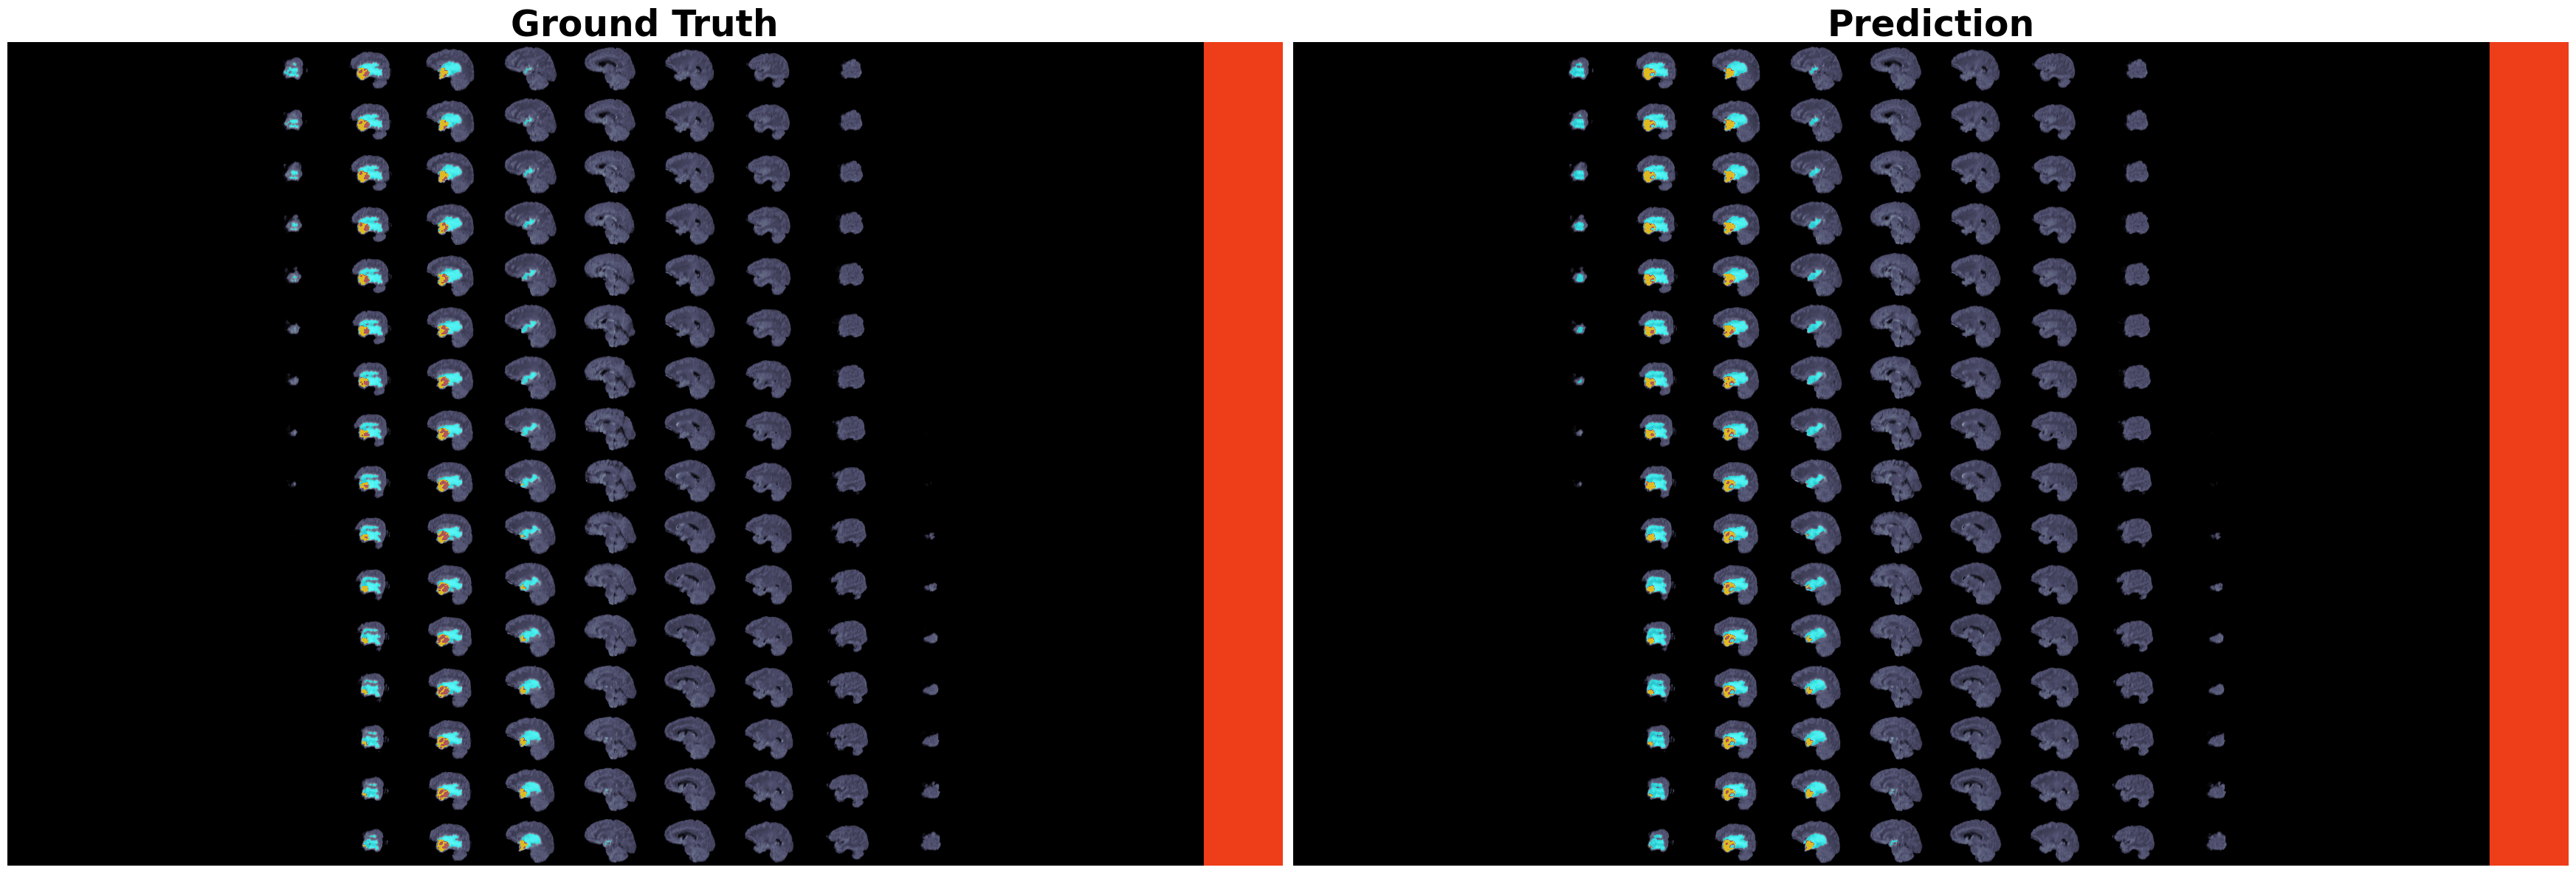

In [ ]:
show_result = ShowResult()
show_result.plot(image, gt, prediction)

In [ ]:
/Screenshot 2023-06-08 at 5.20.56 PM.png